# Imports

In [1]:
# работа с данными
import numpy as np 
import pandas as pd

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns 

# метрики
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

# алгоритмы машинного ообучения
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# кросс-валидация
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, RepeatedStratifiedKFold

# предобработка и преобразование текстовых признаков
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import RussianStemmer

# от предупреждений 
import warnings
warnings.simplefilter("ignore")

# фиксиурем рандом
random_state = 142

# Описание функций

In [2]:
def cl_fs(
    cl, cl_helper, X_train, y_train, 
    step, ps, features, cv, table_train, 
    table_test, metric, name
    ):
    """ Итеративный отбор доли лучших признаков и проверка метрики на кросс-валидации """

    temp_features = features
    new_feats = []

    for p in ps:

        cl_helper.fit(X_train[temp_features], y_train)

        imp = pd.Series(data = cl_helper.feature_importances_, index = temp_features)

        number_of_feats = len(temp_features)
        h = int(number_of_feats * step)

        temp_features = imp.sort_values().iloc[h:].index
        print (len(temp_features))

        new_feats.append(list(temp_features))

        cv_res = cross_validate(cl, X_train[temp_features], y_train, 
        scoring= metric, n_jobs = -1, cv = cv, 
        return_train_score = True, verbose = 0)

        table_train.loc[name, str(p)] = cv_res['train_score'].mean()
        table_test.loc[name, str(p)] = cv_res['test_score'].mean()

    return new_feats, table_train, table_test


def col_by_bins(df, cols, p):
    "Функция разделения числовых и категориальных признаков на корзины с количеством значений не менее доли p."
    "Функция возвращает обновлённый датасет df и список с названием новых колонок"
    bins_cols = []
   
    for col in cols:

        print (col)

        data_type = df[col].apply(type).mode()[0]
        if data_type == float or data_type == int:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna('isNaN')      
        
        bins_cols.append(col + '_bins' + str(p).replace('.', ''))

        bin_data = df[col].value_counts().sort_index()
        keys = []
        values = []

        k = 1
        i = 0

        while True:
            sums = bin_data.iloc[i:i+k].sum()
            if sums > df.shape[0] * p:
                keys.append(np.array(bin_data.index[i: i+k]))
                values.append(sums)
                i = k + i
                k = 1
            else:
                k += 1
                
            if i + k > len(bin_data):
                keys.append(np.array(bin_data.index[i: i+k]))
                values.append(sums)
                break

        for i, key in enumerate(keys):
            df.loc[df[col].isin(key), col + '_bins' + str(p).replace('.', '')] = i

    df[bins_cols] = df[bins_cols].astype(float)
    return df, bins_cols


def order_values (df, cols, target, prefix = ''):
    "Функция упорядочивания значений признака по среднему значению таргета каждого значения"
    temp = df.copy()
    for col in cols:

        print (col)
        
        values = df.groupby(col).mean()[target].sort_values()
        for i in range(len(values)):
            temp.loc[df[col] == values.index[i], col] = i
        df[col + prefix]  = temp[col]    
    return df

# функция взята с https://www.machinelearningmastery.ru/attribute-relevance-analysis-in-python-iv-and-woe-b5651443fc04/
def calculate_woe_iv(dataset, feature, target):
    "Функция расчёта Weight of evidence и Information Value"
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = -np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * (-dset['WoE'])
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='Value')
    return dset, iv

def print_barhs (df, cols, target):
    "Функция вывода вертикальных столбцов со значениями"
    "Value_counts, Information Value, Shift of target, Weight of Evidence"
    mean_target = df[target].mean()

    for col in cols:
        
        data, iv = calculate_woe_iv(df, col, target)
        
        print()
        print(col, ' ', 'IV score: {:.4f}'.format(iv))
        print()
        x = (df.groupby(col).mean()[target] - mean_target).sort_index().index.to_list()
        y1 = df[col].value_counts().sort_index().values
        y2 = data.sort_values(by = 'Value')['IV']
        y3 = ((df.groupby(col).mean()[target] - mean_target) * df[col].value_counts() / df.shape[0]).sort_index().values
        y4 = data.sort_values(by = 'Value')['WoE']
        

        fig, axs = plt.subplots(1, 4, figsize=(25, 5))

        axs[0].barh(x, y1, height=0.5)
        axs[0].set_title('Value_counts')
        axs[1].barh(x, y2, height=0.5)
        axs[1].set_title('Information value')
        axs[2].barh(x, y3, height=0.5)
        axs[2].set_title('Shift of target')
        axs[3].barh(x, y4, height=0.5)
        axs[3].set_title('Weight of evidence')

        plt.show()
        print()

In [3]:
def order_values_uplift (df, cols, target, prefix = ''):
    "Функция упорядочивания значений признака по среднему значению таргета каждого значения"
    temp = df.copy()
    for col in cols:

        print (col)
        
        values = (df.loc[(df['treatment_flg'] == 1) & (df[target].isna() == False)].groupby(col)[target].mean() - df.loc[(df['treatment_flg'] == 0) & (df[target].isna() == False)].groupby(col)[target].mean()).sort_values()

        for i in range(len(values)):
            temp.loc[df[col] == values.index[i], col] = i
        df[col + prefix]  = temp[col]    
    return df

# Загрузка и обзор данных

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train_purch = pd.read_csv('data/train_purch.csv')
test_purch = pd.read_csv('data/test_purch.csv')
clients2 = pd.read_csv('data/clients2.csv')
products = pd.read_csv('data/products.csv')

In [5]:
df = pd.concat([train, test])
df

,client_id,treatment_flg,purchased
0,ad6561e2d8,1.0,1.0
1,7c1ccbf93f,1.0,1.0
2,b58fadcab6,1.0,1.0
3,e99e6fabb9,0.0,0.0
4,27fb6f8520,1.0,1.0
...,...,...,...
60007,4762fb04c5,NaN,NaN
60008,533d1516e7,NaN,NaN
60009,c93b21a707,NaN,NaN
60010,3fe0668de5,NaN,NaN


In [6]:
df = df.merge(clients2, on = ['client_id']).drop(['client_id.1'], axis = 1)

Преобразуем таргеты. Из 4х классов для предикта. И бинарный для оценки метрики.

In [7]:
cond = [
    df['purchased'].isna() == True,
    (df['treatment_flg'] == 1) & (df['purchased'] == 1),
    (df['treatment_flg'] == 0) & (df['purchased'] == 1),
    (df['treatment_flg'] == 1) & (df['purchased'] == 0),
]
choise = [
    np.NaN,
    0,
    1,
    2
]
df['target'] = np.select(cond, choise, 3)


cond = [
    df['purchased'].isna() == True,
    df['treatment_flg'] == df['purchased']
]
choise = [
    np.NaN,
    1
]
df['target2'] = np.select(cond, choise, 0)

In [8]:
df['test'] = np.where(df['target'].isna() == True, 1, 0)

In [9]:
for col in ['first_issue_date', 'first_redeem_date']:
    df[col] = pd.DatetimeIndex(df[col])
    df[col + '_date_year'] = (df[col]).dt.year
    df[col + '_date_month'] = (df[col]).dt.month
    df[col + '_date_day'] = (df[col]).dt.day
    df[col + '_date_day_of_the_week'] = (df[col]).dt.dayofweek
    df[col + '_time_series'] = df[col + '_date_year'] * 365 + df[col + '_date_month'] * 30.5 + df[col + '_date_day']

# время до первой покупки
df['time_to_purch'] = df['first_redeem_date_time_series'] - df['first_issue_date_time_series']

In [10]:
df.gender.value_counts(dropna = False)

U    92832
F    73696
M    33511
Name: gender, dtype: int64

In [11]:
df.groupby(['gender'])['target'].mean()

gender
F    1.222735
M    1.257116
U    1.291511
Name: target, dtype: float64

In [12]:
df['gender'] = df['gender'].map({'U': 0, 'M': 1, 'F': 2})

In [13]:
df.drop(['first_issue_date', 'first_redeem_date'], axis = 1, inplace = True)

In [14]:
df2 = pd.concat([train_purch, test_purch])
df2 = df2.merge(products, on = ['product_id'])
df2 = df2.merge(df[['client_id', 'target', 'target2', 'treatment_flg', 'purchased']], on = ['client_id'])

Для каждого клиента сформируем признаки, основанные на истории его покупок

In [15]:
df2['transaction_datetime'] = pd.DatetimeIndex(df2['transaction_datetime'])
df2['date_year'] = (df2['transaction_datetime']).dt.year
df2['date_month'] = (df2['transaction_datetime']).dt.month
df2['date_day'] = (df2['transaction_datetime']).dt.day
df2['date_day_of_the_week'] = (df2['transaction_datetime']).dt.dayofweek
df2['time_series'] = df2['date_year'] * 365 + df2['date_month'] * 30.5 + df2['date_day']

In [16]:
num_cols = ['regular_points_received', 'express_points_received',
       'regular_points_spent', 'express_points_spent', 'purchase_sum',
       'product_quantity', 'trn_sum_from_iss',
       'trn_sum_from_red','netto', 'time_series'
       ]

cat_cols = [  
       'transaction_id', 'store_id', 'product_id',
       'level_1', 'level_2', 'level_3', 'level_4',
       'segment_id', 'brand_id', 'vendor_id','date_day_of_the_week'
       ]

bin_cat_cols = [
       'is_own_trademark',
       'is_alcohol'
       ]

date_cols = [
       'date_year', 
       'date_month', 
       'date_day'
       ]


df2[cat_cols] = df2[cat_cols].fillna('isnan')

df2[cat_cols].nunique()

df2['segment_id'] = df2['segment_id'].astype(str)

# Client features

In [17]:
for col in cat_cols:
    mapping = df2[col].value_counts(dropna = False, normalize=True)
    df2[col + '_vc'] = df2[col].map(mapping)

num_cols = num_cols + list(pd.Index(cat_cols) + '_vc')

In [18]:
df3 = pd.DataFrame(index = df['client_id'])
df3 = pd.concat([df3, df2.groupby(['client_id'])['client_id'].count().rename('product_purchase_count')], axis = 1)

In [19]:
for col in cat_cols:
    df3 = pd.concat([df3, df2.groupby(['client_id'])[col].nunique().rename(col + '_nunique')], axis = 1)

In [20]:
for col in num_cols:
    df3 = pd.concat([df3, df2.groupby(['client_id'])[col].mean().rename(col + '_mean')], axis = 1)
    df3 = pd.concat([df3, df2.groupby(['client_id'])[col].median().rename(col + '_median')], axis = 1)
    df3 = pd.concat([df3, df2.groupby(['client_id'])[col].std().rename(col + '_std')], axis = 1)
    df3 = pd.concat([df3, df2.groupby(['client_id'])[col].min().rename(col + '_min')], axis = 1)
    df3 = pd.concat([df3, df2.groupby(['client_id'])[col].max().rename(col + '_max')], axis = 1)

for col in bin_cat_cols + date_cols:
    df3 = pd.concat([df3, df2.groupby(['client_id'])[col].mean().rename(col + '_mean')], axis = 1)
    df3 = pd.concat([df3, df2.groupby(['client_id'])[col].max().rename(col + '_max')], axis = 1)
    df3 = pd.concat([df3, df2.groupby(['client_id'])[col].nunique().rename(col + '_nunique')], axis = 1)

In [21]:
df3['time_series_long'] = df3['time_series_max'].max() - df3['time_series_max']
df3['time_series_short'] = df3['time_series_max'] - df3['time_series_max'].min()
df3['time_series_minmin'] = df3['time_series_max'].max() - df3['time_series_min']

In [22]:
df3 = df3.reset_index()
df3

,client_id,product_purchase_count,transaction_id_nunique,store_id_nunique,product_id_nunique,level_1_nunique,level_2_nunique,level_3_nunique,level_4_nunique,segment_id_nunique,...,date_year_nunique,date_month_mean,date_month_max,date_month_nunique,date_day_mean,date_day_max,date_day_nunique,time_series_long,time_series_short,time_series_minmin
0,ad6561e2d8,206,40,2,135,3,18,47,77,55,...,2,4.859223,12,5,17.990291,30,22,2.0,22.5,116.0
1,7c1ccbf93f,14,2,1,14,3,7,12,13,10,...,1,2.785714,3,2,8.000000,19,2,13.0,11.5,29.5
2,b58fadcab6,248,33,3,117,3,14,40,53,42,...,2,4.975806,12,5,15.733871,31,22,2.0,22.5,117.0
3,e99e6fabb9,47,13,2,38,2,12,21,27,23,...,2,2.851064,12,4,13.361702,27,12,3.0,21.5,106.5
4,27fb6f8520,100,30,4,67,3,15,38,43,34,...,2,3.840000,12,4,16.310000,30,18,0.0,24.5,105.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200034,4762fb04c5,153,30,7,127,3,17,50,79,49,...,2,7.078431,12,5,18.751634,30,16,1.0,23.5,109.0
200035,533d1516e7,16,10,5,14,2,8,11,11,10,...,2,8.687500,12,5,18.437500,31,9,6.0,18.5,116.0
200036,c93b21a707,241,34,2,166,3,16,51,74,54,...,2,4.174274,12,5,14.460581,29,20,1.0,23.5,112.0
200037,3fe0668de5,53,14,2,40,3,10,22,31,25,...,2,2.924528,12,3,12.905660,25,10,5.0,19.5,83.5


## Объединение таблиц

In [23]:
df = df.merge(
    df3,
    on = ['client_id'], 
    )

# X_train, X_test, X_sub

Разделим данные на трейн, тест и часть для предсказаний.  
На трейне проведём отберём признаки, подберём гипперпараметры, проведём кросс-валидацию.  
На тесте проверим результат.
На части для предсказаний сделаем предсказание модели.  

In [24]:
features = df.columns.drop(['client_id', 'target', 'target2','test', 'treatment_flg', 'purchased'])

# # пропуски заменим медианой
# X_train, X_test, y_train, y_test = train_test_split(
#     df.loc[(df['test'] == 0), features].fillna(df[features].median()), 
#     df.loc[(df['test'] == 0), ['target', 'target2']], 
#     test_size= 0.2, 
#     stratify = df.loc[(df['test'] == 0), 'target'],
#     random_state = random_state
# )

X_train = df.loc[(df['test'] == 0), features]#.fillna(df[features].median())
y_train = df.loc[(df['test'] == 0), ['target', 'target2']]

X_predict_train = df.loc[(df['test'] == 0), features]#.fillna(df[features].median())
y_predict_train = df.loc[(df['test'] == 0), ['target', 'target2']]
X_predict_test = df.loc[df['test'] == 1, features]#.fillna(df[features].median())

# Feature selection

В качестве предиктора будем использовать алгоритм градиентного бустинга LightGBM.   
Его преимуществом является скорость базового алгоритма "из коробки" по сравнению с альтернативными алгоритмами град.бустинга.  
Отбирать признаки будем методом встроенного алгоритма LightGBM.  
При отборе признаков будем максимизировать метрику Roc_auc.  

In [28]:
# доля отбрасываемых признаков
step = 0.2

# номера итераций
ps = range(0, 15)

# таблицы для сбора метрики на трейне и тесте
metric_fs_train = pd.DataFrame()
metric_fs_test = pd.DataFrame()

# сплиттер обучающей выборки для кросс-валидации
# cv_splitter = StratifiedKFold(n_splits = 4,  shuffle = True, random_state = random_state)
# cv_splitter = RepeatedStratifiedKFold(n_splits = 4, n_repeats= 4, random_state=random_state)
# cv_splitter = StratifiedKFold(n_splits = 16,  shuffle = True, random_state = random_state)
cv_splitter = RepeatedStratifiedKFold(n_splits = 8, n_repeats= 2, random_state=random_state)

target = 'target'

In [29]:
# предиктор и алгоритм отбора
cl = LGBMClassifier(
    n_jobs = -1,
    random_state=random_state,
    )

#алгоритм отбора с ранжированием по 'gain'
lg_gain = LGBMClassifier(
    n_jobs = -1,
    random_state=random_state,
    importance_type = 'gain',
    )

In [37]:
# # до отбора
# cv_res = cross_validate(
#     cl, X_train[features], 
#     y_train[target], 
#     scoring= ['roc_auc_ovr', 'f1_macro'], 
#     n_jobs = -1, 
#     cv = cv_splitter, 
#     return_train_score = True,
#         verbose = 0
#         )

# roc_auc = cv_res['test_roc_auc_ovr'].mean()
# gini = 2*roc_auc - 1

# print ('roc_auc =',roc_auc)
# print ('cv_f1_macro =', cv_res['test_f1_macro'].mean())
# print ('gini =', gini)

roc_auc = 0.6898656165815498
cv_f1_macro = 0.35401545145756896
gini = 0.37973123316309954


In [30]:
# lgbm_feats, metric_fs_train, metric_fs_test = cl_fs(
#     cl, cl, X_train, y_train[target], step, 
#     ps, features, cv_splitter, metric_fs_train, 
#     metric_fs_test, 'roc_auc_ovr', 'lgbm'
#     )

lgbm_gain_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, lg_gain, X_train, y_train[target],
    step, ps, features, cv_splitter, 
    metric_fs_train, metric_fs_test, 'roc_auc_ovr', 'lgbm_gain'
    )


119
96
77
62
50
40
32
26
21
17
14
12
10
8
7
119
96
77
62
50
40
32
26
21
17
14
12
10
8
7


In [31]:
metric_fs_test.iloc[np.where(metric_fs_test == metric_fs_test.max().max())]

,9
lgbm_gain,0.69115


In [32]:
metric_fs_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
lgbm,0.690007,0.690128,0.690059,0.690356,0.690384,0.690749,0.690621,0.690952,0.690900,0.690591,0.690556,0.690545,0.687253,0.687200,0.686986
lgbm_gain,0.690007,0.690043,0.690130,0.690218,0.690518,0.690744,0.690922,0.691085,0.691136,0.691150,0.690858,0.690829,0.690694,0.690519,0.690237


In [33]:
metric_fs_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
lgbm,0.751771,0.751306,0.749932,0.748276,0.746405,0.744306,0.741860,0.739609,0.737108,0.734156,0.731934,0.729661,0.725291,0.721980,0.719902
lgbm_gain,0.751771,0.751275,0.750037,0.748010,0.746498,0.744454,0.741469,0.738726,0.736208,0.733470,0.730016,0.727746,0.724949,0.722279,0.719298


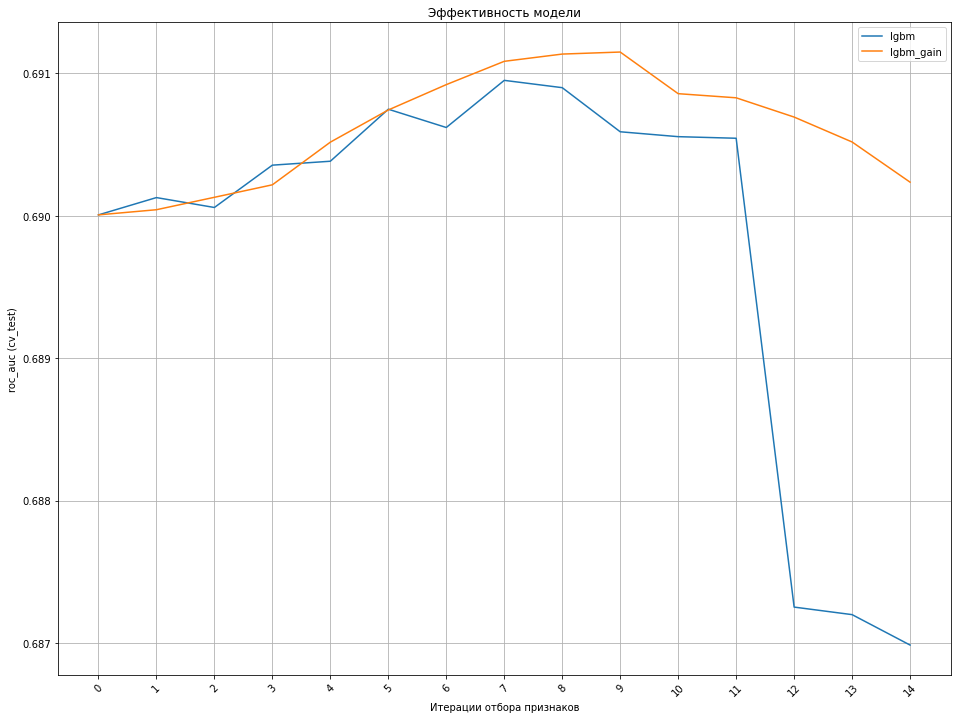

In [34]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in metric_fs_test.index:
    ax.plot(metric_fs_test.columns, metric_fs_test.loc[i, :], label=i)
ax.legend()
plt.title("Эффективность модели")
ax.set_xlabel('Итерации отбора признаков')
ax.set_ylabel('roc_auc (cv_test)')
ax.grid(True)
plt.xticks(metric_fs_test.columns, rotation = 45)
plt.show()

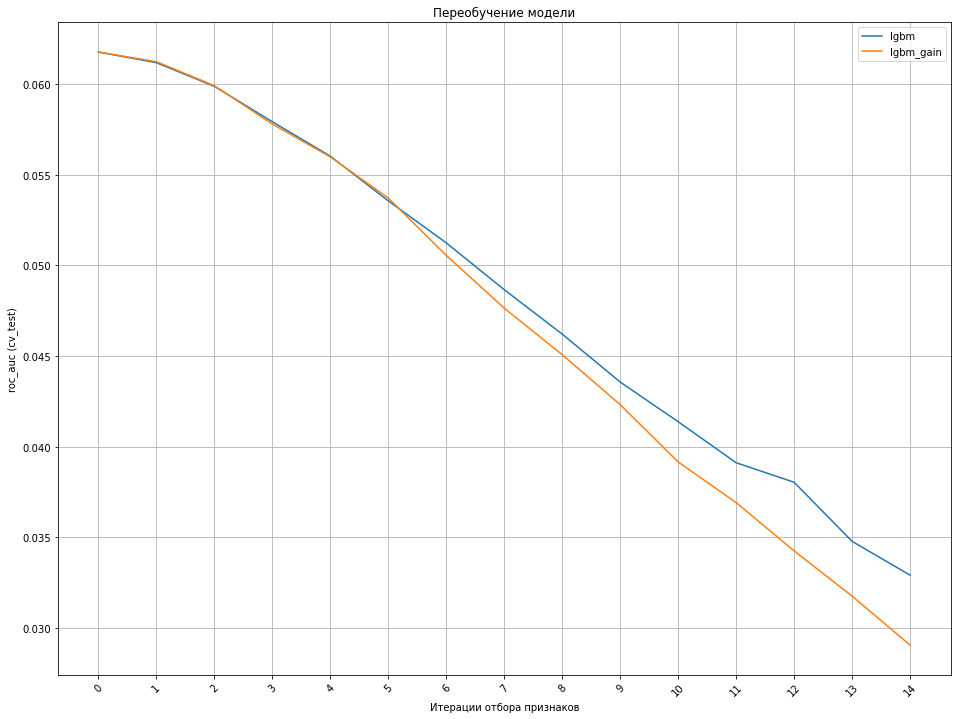

In [35]:
fig, ax = plt.subplots(figsize=(16, 12))

metric_fs_diff = metric_fs_train - metric_fs_test

for i in metric_fs_diff.index:
    ax.plot(metric_fs_diff.columns, metric_fs_diff.loc[i, :], label=i)
ax.legend()
plt.title("Переобучение модели")
ax.set_xlabel('Итерации отбора признаков')
ax.set_ylabel('roc_auc (cv_test)')
ax.grid(True)
plt.xticks(metric_fs_diff.columns, rotation = 45)
plt.show()

In [36]:
new_feats = lgbm_gain_feats[9]
new_feats

['purchase_sum_std',
 'vendor_id_vc_std',
 'level_2_vc_mean',
 'date_day_mean',
 'level_4_vc_std',
 'product_id_vc_min',
 'age',
 'product_purchase_count',
 'first_issue_date_time_series',
 'time_to_purch',
 'time_series_std',
 'first_redeem_date_date_day',
 'time_series_mean',
 'first_redeem_date_time_series',
 'time_series_max',
 'date_day_nunique',
 'transaction_id_nunique']

In [38]:
new_feats = ['purchase_sum_std',
 'vendor_id_vc_std',
 'level_2_vc_mean',
 'date_day_mean',
 'level_4_vc_std',
 'product_id_vc_min',
 'age',
 'product_purchase_count',
 'first_issue_date_time_series',
 'time_to_purch',
 'time_series_std',
 'first_redeem_date_date_day',
 'time_series_mean',
 'first_redeem_date_time_series',
 'time_series_max',
 'date_day_nunique',
 'transaction_id_nunique']

In [ ]:
# # после отбора
# cv_res = cross_validate(
#     cl, X_train[new_feats], 
#     y_train[target], 
#     scoring= ['roc_auc_ovr', 'f1_macro'], 
#     n_jobs = -1, 
#     cv = cv_splitter, 
#     return_train_score = True,
#         verbose = 0
#         )

# roc_auc = cv_res['test_roc_auc_ovr'].mean()
# gini = 2*roc_auc - 1

# print ('roc_auc =',roc_auc)
# print ('cv_f1_macro =', cv_res['test_f1_macro'].mean())
# # print ('cv_precision =', cv_res['test_precision'].mean())
# # print ('cv_recall =', cv_res['test_recall'].mean())
# print ('gini =', gini)

roc_auc = 0.6912504174465909
cv_f1_macro = 0.3541467333121581
gini = 0.38250083489318176


In [ ]:
# cv_res = np.array([])
# for train_index, test_index in cv_splitter.split(X_train[new_feats], y_train[target]):
#     cl.fit(X_train.iloc[train_index][new_feats], y_train.iloc[train_index][target])
#     predict_proba = cl.predict_proba(X_train.iloc[test_index][new_feats])
#     predict = predict_proba[:,0] + predict_proba[:,3]
#     roc_auc = roc_auc_score(y_train.iloc[test_index]['target2'], predict)
#     cv_res = np.append(cv_res, roc_auc)
# print ('gini =', 2*cv_res.mean() - 1)

gini = 0.03614410698686488


Улучшили результат на кросс-валидации.  
Переберём небольшое количество гиперрпараметров.

In [39]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [2, 3, 4, 5, 99]:
        cl = LGBMClassifier(
            n_jobs = -1, 
            max_depth = max_depth,
            random_state = random_state,
            # num_leaves = num_leaves,
            # class_weight = 'balanced'
            )

        cv_res = cross_validate(
            cl, X_train[new_feats], 
            y_train[target], 
            scoring= ['roc_auc_ovr','f1_macro'], 
            n_jobs = -1, 
            cv = cv_splitter, 
            return_train_score = True,
                verbose = 0
                )

        metric_table.loc[i, 'max_depth'] = max_depth
        metric_table.loc[i, 'cv_train'] = cv_res['train_roc_auc_ovr'].mean()        
        metric_table.loc[i, 'cv_roc_auc_ovr'] = cv_res['test_roc_auc_ovr'].mean()
        metric_table.loc[i, 'cv_roc_auc_ovr_std'] = cv_res['test_roc_auc_ovr'].std()
        metric_table.loc[i, 'cv_f1_macro'] = cv_res['test_f1_macro'].mean()

        i+= 1

metric_table = metric_table.sort_values(by = 'cv_roc_auc_ovr', ascending = False)
metric_table['gini'] = 2*metric_table['cv_roc_auc_ovr'] - 1

np.round(metric_table, 3).sort_values(
    by = [
        'cv_roc_auc_ovr', 
        'cv_roc_auc_ovr_std', 
        'max_depth', 
        'cv_f1_macro'],
    ascending = [
        False,
        True,
        False,
        True
    ]
)

,max_depth,cv_train,cv_roc_auc_ovr,cv_roc_auc_ovr_std,cv_f1_macro,gini
2,4.0,0.708,0.692,0.002,0.350,0.384
1,3.0,0.700,0.692,0.002,0.347,0.384
4,99.0,0.733,0.691,0.002,0.351,0.382
3,5.0,0.721,0.691,0.002,0.352,0.383
0,2.0,0.694,0.691,0.002,0.336,0.381


# Predict

In [40]:
max_depth = 4

cl = LGBMClassifier(
            n_jobs = -1, 
            max_depth = max_depth,
            random_state = random_state,
            )

In [41]:
cl.fit(X_predict_train[new_feats], y_predict_train[target])
predict = cl.predict_proba(X_predict_test[new_feats])[:,0] + cl.predict_proba(X_predict_test[new_feats])[:,3]

sample_solution = pd.read_csv('baseline.csv')
sample_solution['pred'] = predict
sample_solution

sample_solution.to_csv('data/solution_19.csv', index = False)